# Equations
Here we are solving a set of coupled differential equations gives (from Chapman supplement and Arne notebook)

$$\begin{align}
    i \dot{\zeta}_1&= (p_1 B + q_1 B^2 + q\mu_1(t))\zeta_1+c\left[(\zeta_1^*\zeta_1+\zeta_0^*\zeta_0-\zeta_{-1}^*\zeta_{-1})\zeta_1+\zeta_0\zeta_0\zeta_{-1}^*)\right]\\
    i\dot{\zeta}_0&=(p_0 B + q_0 B^2 + q\mu_0(t))\zeta_0+c\left[(\zeta_1^*\zeta_1 + \zeta_{-1}^*\zeta_{-1})\zeta_0 + 2\zeta_1\zeta_{-1}\zeta_0^*\right]\\
    i \dot{\zeta}_{-1}&= (p_{-1} B + q_{-1} B^2 + q\mu_{-1}(t))\zeta_{-1}+c\left[(\zeta_{-1}^*\zeta_{-1}+\zeta_0^*\zeta_0-\zeta_{1}^*\zeta_{1})\zeta_{-1}+\zeta_0\zeta_0\zeta_{1}^*)\right]\\
\end{align}
$$

# Expectation Values
First we note that 
$$ S_x = \frac{1}{\sqrt{2}}\begin{pmatrix}
0&1&0\\
1&0&1\\
0&1&0\\
\end{pmatrix}
$$
So to calculate its expectation value with a given wavefunction, we have
$$\psi^*S_x \psi =  (\psi_1^*,\psi_0^*,\psi_{-1}^*)\frac{1}{\sqrt{2}}\begin{pmatrix}
0&1&0\\
1&0&1\\
0&1&0\\
\end{pmatrix}
\begin{pmatrix}
\psi_1\\
\psi_0\\
\psi_{-1}
\end{pmatrix} = \frac{(\psi_1^*+\psi_{-1}^*)\psi_0 + \psi_0^*(\psi_{1}+\psi_{-1})}{\sqrt{2}}$$

# Inital State (Hamley thesis and Chapman supplement)
We can represent the initial state as a normal distribution in $S_x,S_y, N_{yz}, N_{xz}$, we can then derive starting conditions from these values and evolve the state.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from numpy.lib import scimath
%matplotlib inline

In [12]:
#first define the system dy/dt = f(y,t)
def msqr(x):
    return np.conj(x) * x

def f(t,y,*args):
    """system of ode we want to solve"""
    z1i = y[0]
    z0i = y[1]
    zmi = y[2]
    #now define equations
    f0 = (q*z1i + c*((msqr(z1i) + msqr(z0i) - msqr(zmi))*z1i + z0i*z0i*np.conj(zmi)))*np.complex(0,-1)
    f1 = ((q0)*z0i + c*((msqr(z1i) + msqr(zmi))*z0i + 2*z1i*zmi*np.conj(z0i)))*np.complex(0,-1)
    f2 = (q*zmi + c*((msqr(zmi) + msqr(z0i) - msqr(z1i))*zmi + z0i*z0i*np.conj(z1i)))*np.complex(0,-1)
    return [f0,f1,f2]   


In [13]:
#define necessary operators in matrix form
pop_0 = np.array([[0,0,0],[0,1,0],[0,0,0]])
sx = np.array([[0,1,0],[1,0,1],[0,1,0]])*1/np.sqrt(2)
nyz =1j/np.sqrt(2)* np.array([[0,-1,0],[1,0,1],[0,-1,0]])
def apply_operator(op,ele):
    return np.dot(np.conj(ele),np.dot(op,ele.T))

In [14]:
def generate_states(N):
    """generate quasi probability distribution from Chapman paper"""
    sx = np.random.normal(loc = 0, scale = 1/np.sqrt(N), size = int(np.sqrt(N)))
    sy = np.random.normal(loc = 0, scale = 1/np.sqrt(N), size = int(np.sqrt(N)))
    nyz = np.random.normal(loc = 0, scale = 1/np.sqrt(N), size = int(np.sqrt(N)))
    nxz = np.random.normal(loc = 0, scale = 1/np.sqrt(N), size = int(np.sqrt(N)))
    txipi = -(sy + nyz)/(sx + nxz)
    tximi = (sy-nyz)/(sx-nxz)
    def pos(x):
        if x < 0:
            return x + np.pi
        else:
            return x
    txip = np.asarray([pos(i) for i in txipi])
    txim = np.asarray([pos(i) for i in tximi])
    
   
    a = (sx+nxz)**2/(np.cos(np.arctan(txip)))**2
    b = (sx-nxz)**2/(np.cos(np.arctan(txim)))**2
   

    rho_0 = 1/2 + scimath.sqrt(1/4-1/8*(a+b))
    m = 1/(8 * rho_0)*(a-b)

            
    states = np.zeros((len(m),3),dtype = complex)
    
    states[:,0] = scimath.sqrt((1-rho_0+m)/2) * np.exp(np.arctan(txip)*1j)
    states[:,1] = scimath.sqrt(rho_0)
    states[:,2] = scimath.sqrt((1-rho_0-m)/2) * np.exp(np.arctan(txim)*1j)
    
    return states

In [34]:
#define problem parameters
dt = 2.1e-5
tfinal = 2
#allot arrays

        

#define parameters
B =  .21
q = 2*np.pi*-5
c = 2*np.pi*30
q0 = 0

states = generate_states(4000)

In [51]:
#solve the sucker and plot
def solve_system(y0):
    r = ode(f).set_integrator('zvode')
    r.set_initial_value(y0,0)
    sol = []
    t= []
    while r.successful() and r.t < tfinal:
        r.integrate(tfinal, step = True)
        sol.append(r.y)
        t.append(r.t)
    t = np.asarray([t])
    sol = np.asarray(sol)
    return np.concatenate((t.T,sol), axis = 1)

def get_exp_values(ans,step_size):
    """function to compute expectation values"""
    ans = ans[0]
    sol = ans[:,1:]
    r_0 = np.asarray([rho_0.apply(i) for i in sol[::step_size]]).real
    sx_calc = np.asarray([S_x.apply(i) for i in sol[::step_size]]).real
    nyz_calc = np.asarray([N_yz.apply(i) for i in sol[::step_size]]).real
    phase = np.asarray([find_phase(i) for i in sol[::step_size]]).real
    return np.asarray([ans[:,0][::step_size].real,r_0, sx_calc, nyz_calc, phase])

In [52]:
#alot array for computation
step_size = 55
ans = []
#do calculation
for i,state in enumerate(states):
    ans.append(get_exp_values(solve_system(state),step_size))

(4,)


IndexError: too many indices for array

In [54]:
sol = solve_system(states[0])
#get_exp_values(sol,55)
sol.shape

(1863, 4)

TypeError: list indices must be integers or slices, not tuple

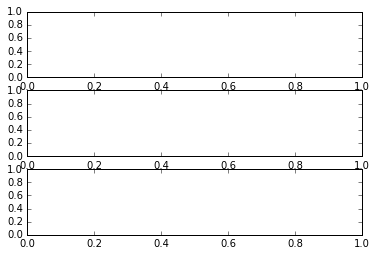

In [40]:
fig, ax = plt.subplots(3,1)
for i in range(3):
    m = np.mean(ans[:,i],axis = 0)
    s = np.std(ans[:,i],axis = 0)
    ax[i].plot(t[::step_size],m)
    ax[i].fill_between(t[::step_size,],m-s,m+s,facecolor='green',alpha=0.3)
plt.tight_layout()

In [12]:
#check state generate
N = 45000
state = generate_states(N)

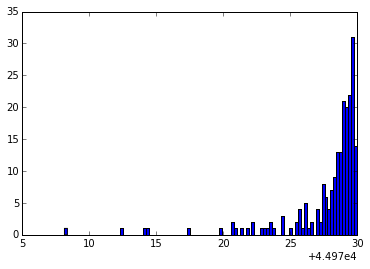

In [13]:
plt.hist(N*msqr(state[:,1]).real,bins = 100);

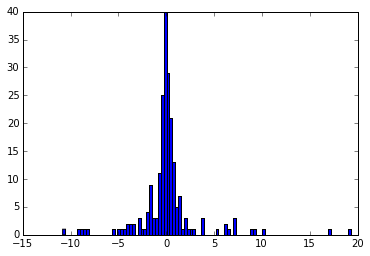

In [14]:
plt.hist(N * (msqr(state[:,2]).real-msqr(state[:,0]).real),bins = 100);